In [1]:
import sys
sys.path.append('..')
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ['DISPLAY'] = ':10'

In [8]:
import numpy as np
import h5py
import os
from os.path import join
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import yaml
import torch
# import ipyplot
import matplotlib
import scipy
import cv2
import glob
import itertools
from tqdm.notebook import tqdm
import pickle as pkl
from scipy.spatial.transform.rotation import Rotation
from torch_scatter import scatter_add
from pytorch3d.transforms.rotation_conversions import quaternion_to_matrix
import trimesh
import copy
import torch_scatter
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.colors
import mediapy as media
import PIL
import io
import matplotlib.patches
from IPython.display import HTML as html_print
import importlib
from IPython.lib.deepreload import reload
from torch.utils.data import Dataset

2022-12-12 21:39:23.774580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 21:39:28.881435: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ccn2/u/rmvenkat/chpatel/envs/physvec2/lib/python3.7/site-packages/cv2/../../lib64:
2022-12-12 21:39:28.881690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ccn2/u/rmvenkat/chpatel/envs/physvec2/lib/pyt

In [6]:

from utils.renderer import MeshViewer
from utils.viz_utils import plot_sequence_images, dcn, viz_points
from dataset.data_utils import nested_shallow_dict, load_entire_hdf5


from dataset.data_utils import store_hdf5_data, nested_shallow_dict, process_movi_tfds_example, recursive_to_tensor


In [7]:
def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
    if num_objects is None:
        num_objects = np.max(seg)  # assume consecutive numbering
    num_objects += 1  # background
    if palette is None:
        palette = [bg_color] + sns.color_palette('hls', num_objects-1)

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
    for i in range(num_objects):
        seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
    return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
    cmap = np.array(colormap.colors)
    if sqrt:
        d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
    else:
        d = np.round(depth[..., 0] // 256).astype(np.uint8)
    return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
    magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
    rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

def plot_bboxes(sample, palette=None, linewidth=1):
    resolution = sample["video"].shape[-3:-1]

    bboxes = sample["instances"]["bboxes"]
    bbox_frames = sample["instances"]["bbox_frames"]
    num_objects = bboxes.shape[0]
    if palette is None:
        palette = sns.color_palette('hls', num_objects)
    images = []
    for t, rgb in enumerate(sample["video"]):
        fig, ax = plt.subplots(figsize=(resolution[0]/100, resolution[1]/100), dpi=132.5)
        ax.axis("off")
        ax.imshow(rgb)
        for k in range(num_objects):
            if t in bbox_frames[k]:
                idx = np.nonzero(bbox_frames[k] == t)[0][0]

                miny, minx, maxy, maxx = bboxes[k][idx]
                miny = max(1, miny*resolution[0])
                minx = max(1, minx*resolution[1])
                maxy = min(resolution[0]-1, maxy*resolution[0])
                maxx = min(resolution[1]-1, maxx*resolution[1])
                rect = matplotlib.patches.Rectangle([minx, miny], maxx-minx, maxy-miny,
                                                    linewidth=linewidth, edgecolor=palette[k],
                                                    facecolor='none')
                ax.add_patch(rect)


        for k in range(num_objects):
            x, y = sample["instances"]["image_positions"][k, t] * resolution
            if np.all(1 < y < resolution[0]-1) and np.all(1 < x < resolution[1]-1):
                ax.scatter(x, y, marker="X", s=5, color=palette[k])
        buf = io.BytesIO()
        fig.savefig(buf, format = "png", bbox_inches = 'tight', pad_inches = 0, dpi=132.5)
        plt.close(fig)
        buf.seek(0)
        img = PIL.Image.open(buf)
        images.append(np.array(img)[..., :3])
    return images

def getsize(arr): 
    if isinstance(arr, np.ndarray):
        return arr.nbytes
    elif isinstance(arr, dict):
        return sum([getsize(v) for v in arr.values()])
    elif isinstance(arr, list):
        return sum([getsize(v) for v in arr])
    else:
        return sys.getsizeof(arr)

def print_instance_ids(sample, ds_info, palette=None):
    if palette is None:
        palette = sns.color_palette('hls', sample["metadata"]["num_instances"])
    out = ''
    if "asset_id" in sample["instances"]:
        ids = [s.decode() for s in sample["instances"]["asset_id"]]
    else:
        labels = []
        if "size_label" in sample["instances"]:
            labels.append([ds_info.features["instances"]["size_label"].names[k]
                           for k in sample["instances"]["size_label"]])
        if "color_label" in sample["instances"]:
            labels.append([ds_info.features["instances"]["color_label"].names[k]
                           for k in sample["instances"]["color_label"]])
        labels.append([ds_info.features["instances"]["material_label"].names[k]
                           for k in sample["instances"]["material_label"]])
        labels.append([ds_info.features["instances"]["shape_label"].names[k]
                       for k in sample["instances"]["shape_label"]])
        ids = [" ".join(x) for x in zip(*labels)]

    for i, (color, asset_id) in enumerate(zip(palette, ids)):
        color_hex = '#%02x%02x%02x' % tuple(int(x*255) for x in color)
        out += f'{i}.'
    
    return html_print(out)

rgb,segmentation,depth,normal
forward_flow,backward_flow,object_coordinates,bboxes/center_of_mass

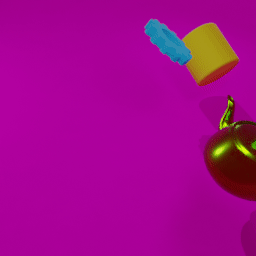
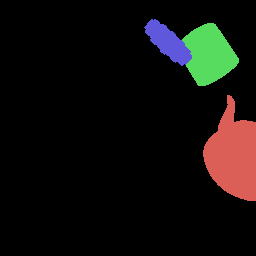
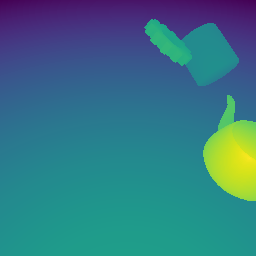
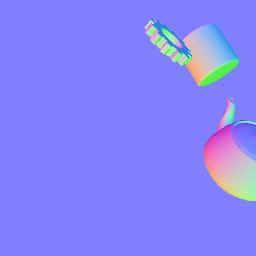
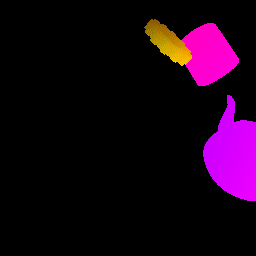
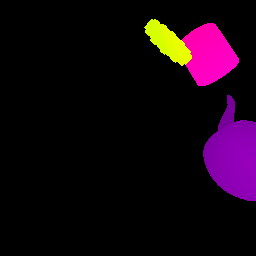
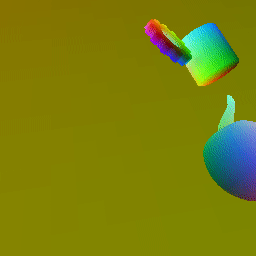
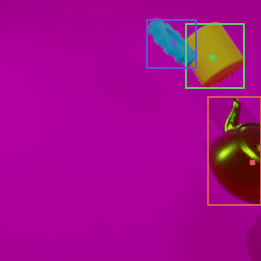

In [12]:
def show_one_sample_all():
    minv, maxv = example["metadata"]["forward_flow_range"]
    forward_flow = example["forward_flow"] / 65535 * (maxv - minv) + minv

    minv, maxv = example["metadata"]["backward_flow_range"]
    backward_flow = example["backward_flow"] / 65535 * (maxv - minv) + minv

    minv, maxv = example["metadata"]["depth_range"]
    depth = example["depth"] / 65535 * (maxv - minv) + minv

    media.show_videos({"rgb": example["video"], 
                       "segmentation": [segmentation_to_rgb(s, num_objects=example["metadata"]["num_instances"])
                                        for s in example["segmentations"]],
                       "depth": depth_to_rgb(example["depth"], sqrt=True),
                       "normal": example["normal"],
                       "forward_flow": flow_to_rgb(forward_flow, white_bg=False),
                       "backward_flow": flow_to_rgb(backward_flow, white_bg=False),
                       "object_coordinates": example["object_coordinates"], 
                       "bboxes/center_of_mass": plot_bboxes(example),
                       },
                    fps=12,
                    columns=4,
                    codec="gif",
    )
    print_instance_ids(example, ds_info)

show_one_sample_all()

In [9]:
ds, ds_info = tfds.load('movi_b', data_dir="gs://kubric-public/tfds", with_info=True)

2022-12-12 21:39:54.658802: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2022-12-12 21:39:59.672915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 21:40:21.786914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39553 MB memory:  -> device: 0, name: 

In [10]:
ds_iter = iter(tfds.as_numpy(ds['train']))

In [11]:
example = next(ds_iter)

In [15]:
example['instances']['mass']

array([2.1967092 , 1.4185354 , 0.12905008], dtype=float32)

In [18]:
KUBASIC_MASSES = [0.9936, 0.7808, 0.5225, 0.4774, 0.2627, 0.2842, 0.2724, 0.5476, 0.2763, 0.3227, 0.3113]

def get_scale(example):
    base_masses = np.array([KUBASIC_MASSES[sid] for sid in example['instances']['shape_label']])
    mults = np.zeros_like(base_masses)
    mults[example['instances']['material_label'] == 0] = 2.7
    mults[example['instances']['material_label'] == 1] = 1.1
    example['instances']['scale'] = np.cbrt(example['instances']['mass'] / base_masses / mults)
    return example

In [20]:
example = get_scale(example)

In [22]:
example['instances'].keys()

dict_keys(['angular_velocities', 'bbox_frames', 'bboxes', 'bboxes_3d', 'color', 'friction', 'image_positions', 'mass', 'material_label', 'positions', 'quaternions', 'restitution', 'shape_label', 'velocities', 'visibility', 'scale'])

In [38]:
np.random.choice([0, 1], size=(10,), p=[1./4, 3./4]).astype(bool)

array([False,  True,  True,  True,  True,  True,  True, False,  True,
        True])

In [41]:
np.random.permutation([True, False, False])

array([ True, False, False])